# Keras MNIST classifier with _distributed_ random-search hyper-parameter optimization

In [135]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os

# External imports
import ipyparallel as ipp
import numpy as np
import matplotlib.pyplot as plt
import keras

# Local imports
from mnist import load_data, build_model

%matplotlib notebook

## Connect to cluster

In [2]:
# Use default profile for now
c = ipp.Client()
print('Worker IDs:', c.ids)

Worker IDs: [0, 1]


## Load the data

In [3]:
x_train, y_train, x_test, y_test = load_data()

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


## Configure the tasks

In [137]:
def build_and_train(x_train, y_train, valid_frac, batch_size, n_epochs,
                    h1, h2, h3, dropout, optimizer, verbose=0,
                    checkpoint_file=None):
    """Run training for one set of hyper-parameters.
    TODO: add support for model checkpointing."""
    from mnist import build_model
    import keras
    if optimizer == 'Adam':
        opt_type = keras.optimizers.Adam
    elif optimizer == 'Nadam':
        opt_type = keras.optimizers.Nadam
    elif optimizer == 'Adadelta':
        opt_type = keras.optimizers.Adadelta
    else:
        raise Exception('Unsupported optimizer type %s' % optimizer)
    # Build the model
    model = build_model(h1=h1, h2=h2, h3=h3,
                        dropout=dropout,
                        optimizer_type=opt_type)
    model.summary()
    callbacks = []
    if checkpoint_file is not None:
        callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_file))
    # Train the model
    history = model.fit(x_train, y_train,
                        validation_split=valid_frac,
                        batch_size=batch_size, epochs=n_epochs,
                        verbose=verbose, callbacks=callbacks)
    return history.history

In [138]:
# Temporarily making things reproducible for development
np.random.seed(0)

# Define the hyper-parameter search points
n_hpo_trials = 2
grid_h1 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h2 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h3 = np.random.choice([8, 16, 32, 64, 128], size=n_hpo_trials)
grid_dropout = np.random.rand(n_hpo_trials)
grid_optimizer = np.random.choice(['Adadelta', 'Adam', 'Nadam'], size=n_hpo_trials)

# Training config
batch_size = 128
n_epochs = 2
valid_frac = 0.17
checkpoint_dir = '/global/cscratch1/sd/sfarrell/cori-interactive-dl/mnist_hpo'

## Run the trainings

In [139]:
# Load-balanced view
lv = c.load_balanced_view()

# Loop over hps
results = []
params = zip(grid_h1, grid_h2, grid_h3, grid_dropout, grid_optimizer)
for ihp, (h1, h2, h3, dropout, optimizer) in enumerate(params):
    print('Hyper-parameter trial', ihp)
    print('  Hidden %i, %i, %i' % (h1, h2, h3))
    print('  Dropout %.4f' % dropout)
    print('  Optimizer', optimizer)
    checkpoint_file = os.path.join(checkpoint_dir, 'model_%i.h5' % ihp)
    result = lv.apply(build_and_train,
                      x_train, y_train,
                      valid_frac=valid_frac,
                      batch_size=batch_size, n_epochs=n_epochs,
                      h1=h1, h2=h2, h3=h3,
                      dropout=dropout, optimizer=optimizer,
                      checkpoint_file=checkpoint_file, verbose=2)
    results.append(result)

Hyper-parameter trial 0
  Hidden 64, 32, 64
  Dropout 0.6236
  Optimizer Nadam
Hyper-parameter trial 1
  Hidden 4, 32, 16
  Dropout 0.3844
  Optimizer Adadelta


In [141]:
histories = [ar.get() for ar in results]

## Model selection and evaluation

In [142]:
last_scores = np.array([h['val_acc'][-1] for h in histories])
best_scores = np.array([max(h['val_acc']) for h in histories])

### Best model

Hyperparameters: trial 0 hidden 64-32-64 dropout 0.624 opt Nadam
  Last validation accuracy 0.9752
  Best validation accuracy 0.9752


<IPython.core.display.Javascript object>


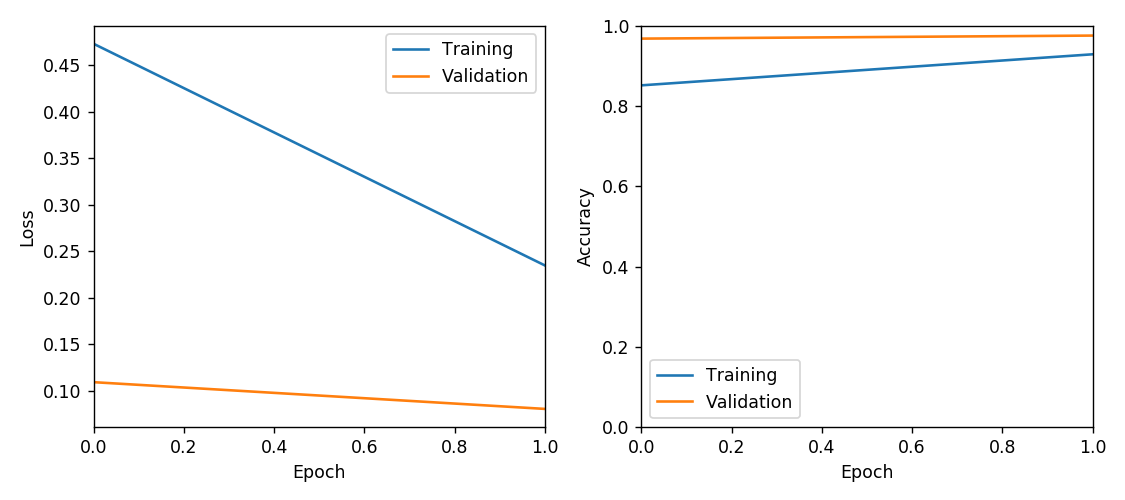

In [144]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmax()
h = histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h['loss'], label='Training')
plt.plot(h['val_loss'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h['acc'], label='Training')
plt.plot(h['val_acc'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Worst model

Hyperparameters: trial 1 hidden 4-32-16 dropout 0.384 opt Adadelta
  Last validation accuracy 0.9684
  Best validation accuracy 0.9684


<IPython.core.display.Javascript object>


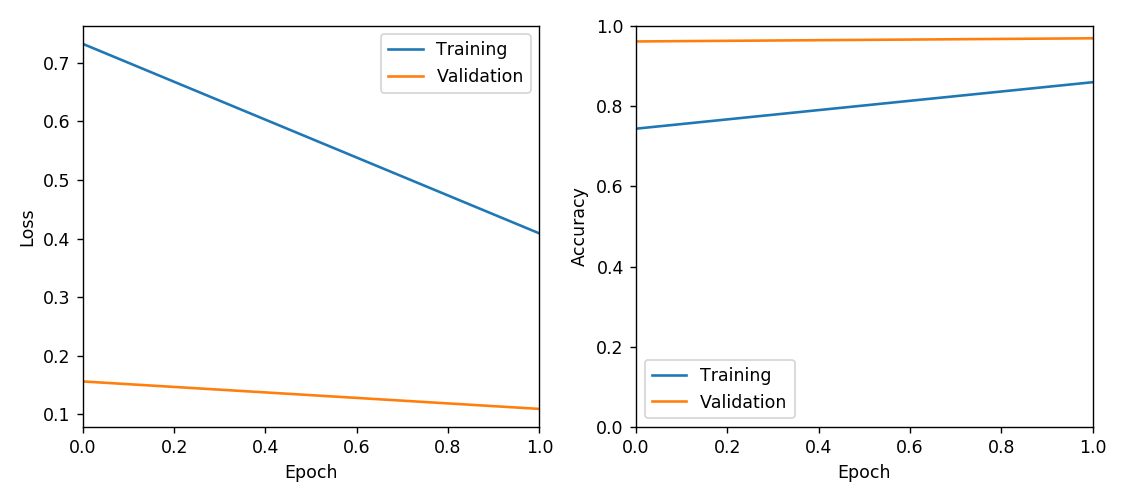

In [145]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmin()
h = histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h['loss'], label='Training')
plt.plot(h['val_loss'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h['acc'], label='Training')
plt.plot(h['val_acc'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Test set evaluation

Here we load the best selected model and evaluate final performance on the test set.

In [146]:
i = best_scores.argmax()
model_file = os.path.join(checkpoint_dir, 'model_%i.h5' % i)
model = keras.models.load_model(model_file)

In [150]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [155]:
print('Test loss: %.4f' % test_loss)
print('Test accuracy: %.4f' % test_acc)

Test loss: 0.0843
Test accuracy: 0.9739
